In [10]:
import sys
import os

# Add Codes/src to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src')))

In [11]:
import pandas as pd
import numpy as np
import torch
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

from train_utils import BatteryTrainerBase

In [12]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [13]:
df = pd.read_pickle('../../../Datasets/processed/merged_interp_flat.pkl')
df.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,dqdt_min,dqdt_max,dqdt_mean,dqdt_std,dvdt_min,...,i_interp_991,i_interp_992,i_interp_993,i_interp_994,i_interp_995,i_interp_996,i_interp_997,i_interp_998,i_interp_999,source
0,B0005,2.0,1,1.856487,0.928244,-1.332504e-07,0.002876,0.000528,0.000255,-0.006229,...,0.004819,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,nasa
1,B0005,2.0,3,1.846327,0.923164,-4.510385e-07,0.002894,0.000527,0.000257,-0.006004,...,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,nasa
2,B0005,2.0,5,1.835349,0.917675,-1.163391e-07,0.002333,0.000520,0.000227,-0.005953,...,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,nasa
3,B0005,2.0,7,1.835263,0.917631,-2.062661e-07,0.002885,0.000530,0.000255,-0.005907,...,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,nasa
4,B0005,2.0,9,1.834646,0.917323,-5.353266e-07,0.002896,0.000530,0.000256,-0.005923,...,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,nasa


In [24]:
class BatteryTrainer(BatteryTrainerBase):
    def train(self, train_df, val_df, feature_cols=None, **model_kwargs):
        ###
        # UBAH DISINI SESUAI MODEL MASING MASING
        ###
        # n_estimators=100, learning_rate=0.1, max_depth=6
        X_train = train_df[feature_cols].values
        y_train = train_df[self.target_cols].values.ravel()
        X_val = val_df[feature_cols].values
        y_val = val_df[self.target_cols].values.ravel()

        model = RandomForestRegressor(
            random_state=42, 
            n_jobs=-1,
            n_estimators=model_kwargs.get("n_estimators", 200),
            max_depth=model_kwargs.get("max_depth", 10),
            min_samples_split=model_kwargs.get("min_samples_split", 2)

        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        print(f"RandomForest Val MSE={mean_squared_error(y_val, y_pred):.4f}, MAE={mean_absolute_error(y_val, y_pred):.4f}, R²={r2_score(y_val, y_pred):.4f}")

        return model, y_val, y_pred
    
    def optuna_objective(self, trial):
        ###
        # UBAH DISINI SESUAI MODEL MASING MASING
        ###
        n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 300])
        max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
        min_samples_split = trial.suggest_categorical("min_samples_split", [2, 5])

        result = self.cross_validate(
            n_estimators=n_estimators,
            # learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split
        )

        return result.avg_mse

In [25]:
trainer = BatteryTrainer(df, target_cols=['soh'])

In [26]:
result = trainer.cross_validate()


=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0143, R²=0.9799
  MSE: 0.0011, MAE: 0.0143, R²: 0.9799

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0187, R²=0.9520
  MSE: 0.0016, MAE: 0.0187, R²: 0.9520

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0128, R²=0.9764
  MSE: 0.0011, MAE: 0.0128, R²: 0.9764

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0174, R²=0.9275
  MSE: 0.0027, MAE: 0.0174, R²: 0.9275

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0010, MAE=0.0085, R²=0.9865
  MSE: 0.

In [27]:
study = trainer.run_optuna_tuning()

[I 2025-04-17 12:58:26,530] A new study created in memory with name: no-name-287593ae-abb9-4f8b-9256-64c9a163b21f



=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0140, R²=0.9802
  MSE: 0.0011, MAE: 0.0140, R²: 0.9802

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0174, R²=0.9534
  MSE: 0.0016, MAE: 0.0174, R²: 0.9534

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0122, R²=0.9764
  MSE: 0.0011, MAE: 0.0122, R²: 0.9764

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0168, R²=0.9283
  MSE: 0.0027, MAE: 0.0168, R²: 0.9283

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features


[I 2025-04-17 13:41:48,617] Trial 0 finished with value: 0.0014928779614281332 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 0.0014928779614281332.


RandomForest Val MSE=0.0010, MAE=0.0081, R²=0.9866
  MSE: 0.0010, MAE: 0.0081, R²: 0.9866

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0137
Avg R² : 0.9650

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0140, R²=0.9802
  MSE: 0.0011, MAE: 0.0140, R²: 0.9802

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0174, R²=0.9534
  MSE: 0.0016, MAE: 0.0174, R²: 0.9534

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0122, R²=0.9764
  MSE: 0.0011, MAE: 0.0122, R²: 0.9764

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0168, R²=0.9283
  MSE: 0.0027, MAE: 0.0168, R²: 0.9283

=== F

[I 2025-04-17 14:31:04,591] Trial 1 finished with value: 0.0014928779614281332 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 0.0014928779614281332.


RandomForest Val MSE=0.0010, MAE=0.0081, R²=0.9866
  MSE: 0.0010, MAE: 0.0081, R²: 0.9866

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0137
Avg R² : 0.9650

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0012, MAE=0.0147, R²=0.9792
  MSE: 0.0012, MAE: 0.0147, R²: 0.9792

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0185, R²=0.9524
  MSE: 0.0016, MAE: 0.0185, R²: 0.9524

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0128, R²=0.9766
  MSE: 0.0011, MAE: 0.0128, R²: 0.9766

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0174, R²=0.9275
  MSE: 0.0027, MAE: 0.0174, R²: 0.9275

=== F

[I 2025-04-17 15:03:36,985] Trial 2 finished with value: 0.001514791011778526 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 0.0014928779614281332.


RandomForest Val MSE=0.0010, MAE=0.0085, R²=0.9866
  MSE: 0.0010, MAE: 0.0085, R²: 0.9866

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0144
Avg R² : 0.9645

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0143, R²=0.9799
  MSE: 0.0011, MAE: 0.0143, R²: 0.9799

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0187, R²=0.9520
  MSE: 0.0016, MAE: 0.0187, R²: 0.9520

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0128, R²=0.9764
  MSE: 0.0011, MAE: 0.0128, R²: 0.9764

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0174, R²=0.9275
  MSE: 0.0027, MAE: 0.0174, R²: 0.9275

=== F

[I 2025-04-17 15:48:09,475] Trial 3 finished with value: 0.001511456613128096 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 0.0014928779614281332.


RandomForest Val MSE=0.0010, MAE=0.0085, R²=0.9865
  MSE: 0.0010, MAE: 0.0085, R²: 0.9865

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0143
Avg R² : 0.9645

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0136, R²=0.9808
  MSE: 0.0011, MAE: 0.0136, R²: 0.9808

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0174, R²=0.9530
  MSE: 0.0016, MAE: 0.0174, R²: 0.9530

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0124, R²=0.9758
  MSE: 0.0011, MAE: 0.0124, R²: 0.9758

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0168, R²=0.9277
  MSE: 0.0027, MAE: 0.0168, R²: 0.9277

=== F

[I 2025-04-17 16:20:50,727] Trial 4 finished with value: 0.0015002960426299579 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2}. Best is trial 0 with value: 0.0014928779614281332.


RandomForest Val MSE=0.0010, MAE=0.0080, R²=0.9864
  MSE: 0.0010, MAE: 0.0080, R²: 0.9864

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0136
Avg R² : 0.9647

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0140, R²=0.9802
  MSE: 0.0011, MAE: 0.0140, R²: 0.9802

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0174, R²=0.9534
  MSE: 0.0016, MAE: 0.0174, R²: 0.9534

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0122, R²=0.9764
  MSE: 0.0011, MAE: 0.0122, R²: 0.9764

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0168, R²=0.9283
  MSE: 0.0027, MAE: 0.0168, R²: 0.9283

=== F

[I 2025-04-17 16:41:12,900] Trial 5 finished with value: 0.0014928779614281332 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 0.0014928779614281332.


RandomForest Val MSE=0.0010, MAE=0.0081, R²=0.9866
  MSE: 0.0010, MAE: 0.0081, R²: 0.9866

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0137
Avg R² : 0.9650

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0012, MAE=0.0145, R²=0.9795
  MSE: 0.0012, MAE: 0.0145, R²: 0.9795

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0181, R²=0.9535
  MSE: 0.0016, MAE: 0.0181, R²: 0.9535

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0129, R²=0.9760
  MSE: 0.0011, MAE: 0.0129, R²: 0.9760

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0175, R²=0.9271
  MSE: 0.0027, MAE: 0.0175, R²: 0.9271

=== F

[I 2025-04-17 17:06:23,943] Trial 6 finished with value: 0.0015128395949122234 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 0.0014928779614281332.


RandomForest Val MSE=0.0010, MAE=0.0084, R²=0.9865
  MSE: 0.0010, MAE: 0.0084, R²: 0.9865

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0143
Avg R² : 0.9645

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0143, R²=0.9799
  MSE: 0.0011, MAE: 0.0143, R²: 0.9799

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0187, R²=0.9520
  MSE: 0.0016, MAE: 0.0187, R²: 0.9520

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0128, R²=0.9764
  MSE: 0.0011, MAE: 0.0128, R²: 0.9764

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0174, R²=0.9275
  MSE: 0.0027, MAE: 0.0174, R²: 0.9275

=== F

[I 2025-04-17 17:36:40,625] Trial 7 finished with value: 0.0015114566131280963 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 0.0014928779614281332.


RandomForest Val MSE=0.0010, MAE=0.0085, R²=0.9865
  MSE: 0.0010, MAE: 0.0085, R²: 0.9865

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0143
Avg R² : 0.9645

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0138, R²=0.9804
  MSE: 0.0011, MAE: 0.0138, R²: 0.9804

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0177, R²=0.9527
  MSE: 0.0016, MAE: 0.0177, R²: 0.9527

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0123, R²=0.9766
  MSE: 0.0011, MAE: 0.0123, R²: 0.9766

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0167, R²=0.9283
  MSE: 0.0027, MAE: 0.0167, R²: 0.9283

=== F

[I 2025-04-17 18:40:24,970] Trial 8 finished with value: 0.001491951111990982 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}. Best is trial 8 with value: 0.001491951111990982.


RandomForest Val MSE=0.0010, MAE=0.0081, R²=0.9866
  MSE: 0.0010, MAE: 0.0081, R²: 0.9866

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0137
Avg R² : 0.9649

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0143, R²=0.9799
  MSE: 0.0011, MAE: 0.0143, R²: 0.9799

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0187, R²=0.9520
  MSE: 0.0016, MAE: 0.0187, R²: 0.9520

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0128, R²=0.9764
  MSE: 0.0011, MAE: 0.0128, R²: 0.9764

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0174, R²=0.9275
  MSE: 0.0027, MAE: 0.0174, R²: 0.9275

=== F

[I 2025-04-17 20:41:03,120] Trial 9 finished with value: 0.001511456613128096 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 8 with value: 0.001491951111990982.


RandomForest Val MSE=0.0010, MAE=0.0085, R²=0.9865
  MSE: 0.0010, MAE: 0.0085, R²: 0.9865

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0143
Avg R² : 0.9645

Best trial:
  MSE: 0.0015
  Params:
    n_estimators: 200
    max_depth: 20
    min_samples_split: 2


In [28]:
base_model = trainer.train_base_model()


Training base model with default hyperparameters
RandomForest Val MSE=0.0013, MAE=0.0145, R²=0.9774


In [29]:
tuned_model = trainer.train_tuned_model()


Training with best Optuna params:
  n_estimators: 200
  max_depth: 20
  min_samples_split: 2
RandomForest Val MSE=0.0013, MAE=0.0139, R²=0.9776



Running cross-validation for base model...

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0143, R²=0.9799
  MSE: 0.0011, MAE: 0.0143, R²: 0.9799

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0016, MAE=0.0187, R²=0.9520
  MSE: 0.0016, MAE: 0.0187, R²: 0.9520

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0011, MAE=0.0128, R²=0.9764
  MSE: 0.0011, MAE: 0.0128, R²: 0.9764

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val MSE=0.0027, MAE=0.0174, R²=0.9275
  MSE: 0.0027, MAE: 0.0174, R²: 0.9275

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
RandomForest Val

/Users/wisnuraharjo/Documents/CAPSTONE/CS64-Capstone-1/Codes/src/plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/Users/wisnuraharjo/Documents/CAPSTONE/CS64-Capstone-1/Codes/src/plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['Metric'] == metric], x='Model', y='Score', palette='Set2', ax=ax)
/Users/wisnuraharjo/Documents/CAPSTONE/CS64-Capstone-1/Codes/src/plot_utils.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data

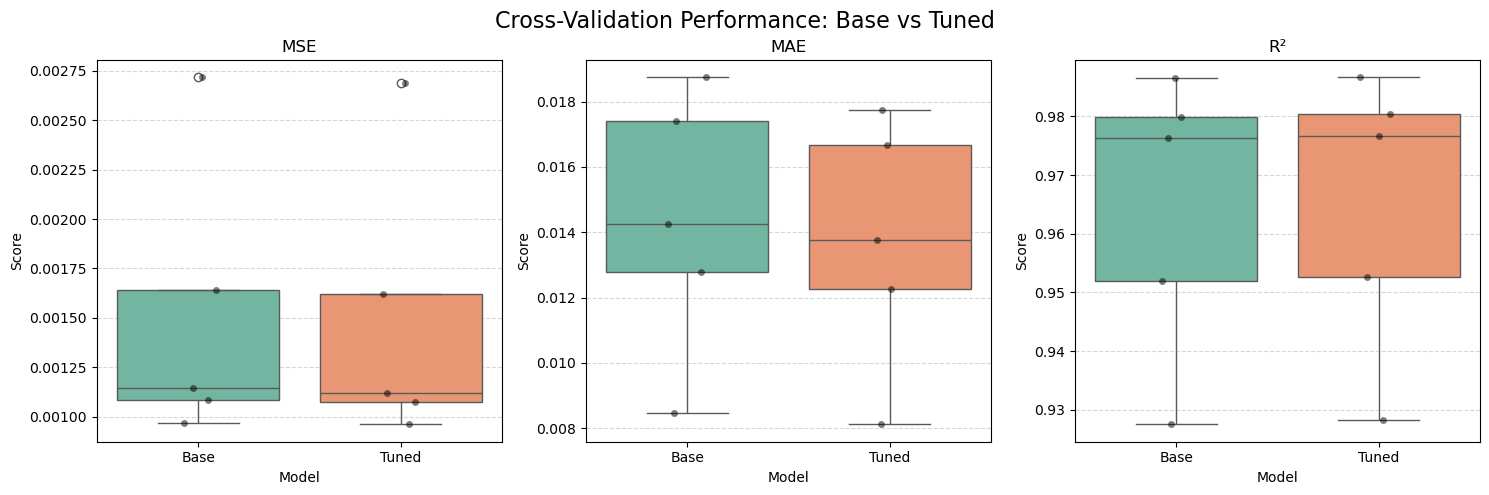

In [30]:
trainer.compare_base_vs_tuned_cv()